In [ ]:

!pip imstall datasets
import pandas as pd
import torch
import numpy as np
from textblob import TextBlob
from transformers import AutoTokenizer
from datasets import Dataset as HFDataset
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import sys
print(sys.executable)

F:\Anaconda\python.exe


In [5]:
# Loading the  dataset paths
train_path = "data/train.tsv"
valid_path = "data/valid.tsv"
test_path = "data/test.tsv"

In [6]:
# Doing Label mapping to Convert to Binary: 1=True, 0=False
LABEL_MAPPING = {
    "true": 1, "mostly-true": 1,
    "half-true": 0, "barely-true": 0, "false": 0, "pants-fire": 0
}

In [7]:
def preprocess_data(file_path):
    df = pd.read_csv(file_path, sep='\t', header=None)
    df.columns = ["id", "label", "statement", "subject", "speaker", "job", "state", "party",
                  "context1", "context2", "context3", "context4", "context5", "source"]
    
    # Converting the Labels to Binary format
    df["label"] = df["label"].map(LABEL_MAPPING)
    
    # Separate handling for numeric and object columns
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col].fillna("unknown", inplace=True)
        else:
            df[col].fillna(0, inplace=True) 
    # Adding the Sentiment Score here 
    df["sentiment"] = df["statement"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    
    return df


In [8]:
# loading and preprocessing the  Datasets
train_df = preprocess_data(train_path)
valid_df = preprocess_data(valid_path)
test_df = preprocess_data(test_path)

# Printing the head to see the columns in the dataset
print(f"Train Shape: {train_df.shape}, Valid Shape: {valid_df.shape}, Test Shape: {test_df.shape}")
print(train_df.head())

Train Shape: (10240, 15), Valid Shape: (1284, 15), Test Shape: (1267, 15)
           id  label                                          statement  \
0   2635.json      0  Says the Annies List political group supports ...   
1  10540.json      0  When did the decline of coal start? It started...   
2    324.json      1  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json      0  Health care reform legislation is likely to ma...   
4   9028.json      0  The economic turnaround started at the end of ...   

                              subject         speaker                   job  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting               unknown   
4                        economy,jobs   charlie-crist               unknown   



In [9]:
def create_three_key_visualizations(train_df, valid_df, test_df):
    # Combining 
    # all datasets for overall analysis
    all_df = pd.concat([train_df, valid_df, test_df], axis=0)
    
    # step 1 Class Distribution with percentages
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x='label', data=all_df, palette=['#FF5555', '#55BB55'])
    
    # Calculate percentages for labels
    total = len(all_df)
    for p in ax.patches:
        count = p.get_height()
        percentage = f'{count} ({count/total*100:.1f}%)'
        ax.annotate(percentage, 
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='bottom', fontsize=12)
    
    plt.title('Distribution of True vs False Claims', fontsize=16)
    plt.xlabel('Label (1=True, 0=False)', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Step 2 Correlation Heatmap between key features
    plt.figure(figsize=(12, 10))
    
    # Add statement length as a feature
    all_df['statement_length'] = all_df['statement'].apply(lambda x: len(str(x).split()))
    
    # Select relevant columns for correlation analysis
    selected_cols = ['label', 'sentiment', 'statement_length', 
                     'context1', 'context2', 'context3', 'context4', 'context5']
    
    # Create correlation matrix
    corr_matrix = all_df[selected_cols].corr()
    
    # Creating heatmap Plot
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", 
                linewidths=0.5, cbar_kws={"shrink": .8})
    
    plt.title('Correlation Heatmap of Features', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # step 3 True vs False distribution by political party
    plt.figure(figsize=(14, 8))
    
    # Get major parties with more than 100 statements
    party_counts = all_df['party'].value_counts()
    major_parties = party_counts[party_counts > 100].index.tolist()
    party_df = all_df[all_df['party'].isin(major_parties)]
    
    # Create cross-tabulation and calculate percentages
    party_truth = pd.crosstab(party_df['party'], party_df['label'])
    party_truth_pct = party_truth.div(party_truth.sum(axis=1), axis=0) * 100
    
    # Plot stacked bar chart
    ax = party_truth_pct.plot(kind='bar', stacked=True, 
                             colormap='coolwarm', figsize=(12, 7))
    
    # Add value labels on bars
    for c in ax.containers:
        labels = [f'{v:.1f}%' if v > 5 else '' for v in c.datavalues]
        ax.bar_label(c, labels=labels, label_type='center')
    
    plt.title('Percentage of True vs False Claims by Political Party', fontsize=16)
    plt.xlabel('Political Party', fontsize=14)
    plt.ylabel('Percentage', fontsize=14)
    plt.legend(['False', 'True'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

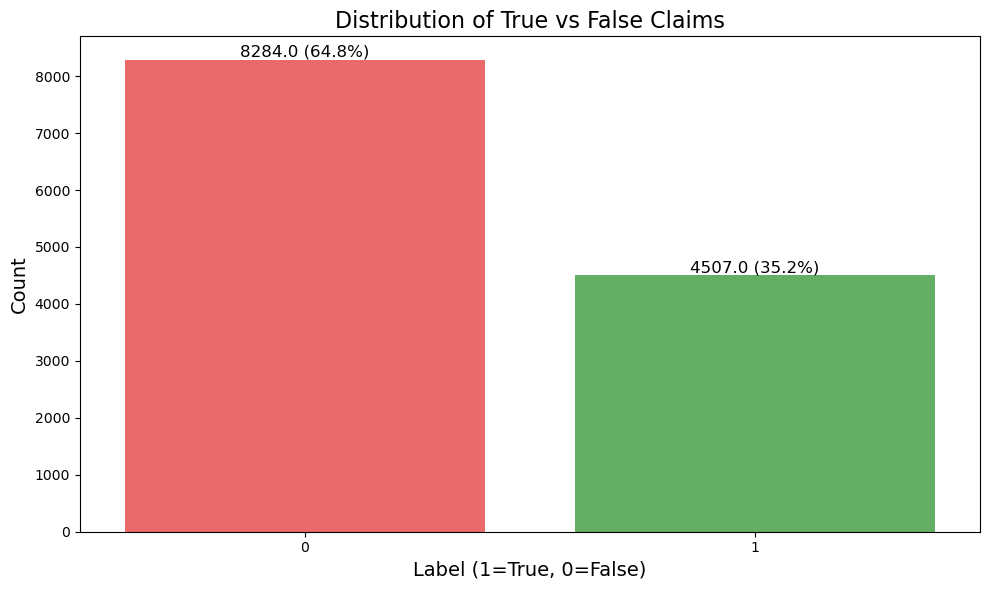

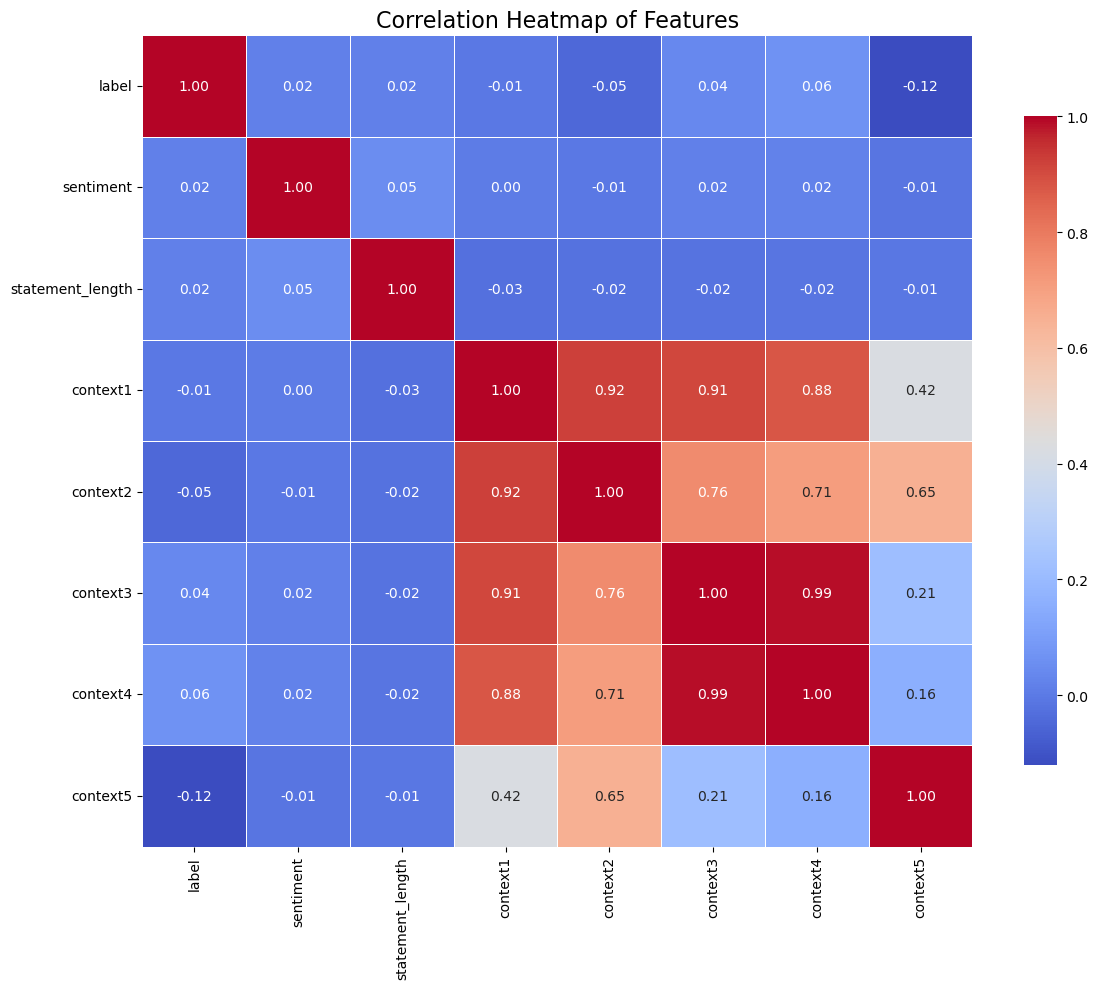

<Figure size 1400x800 with 0 Axes>

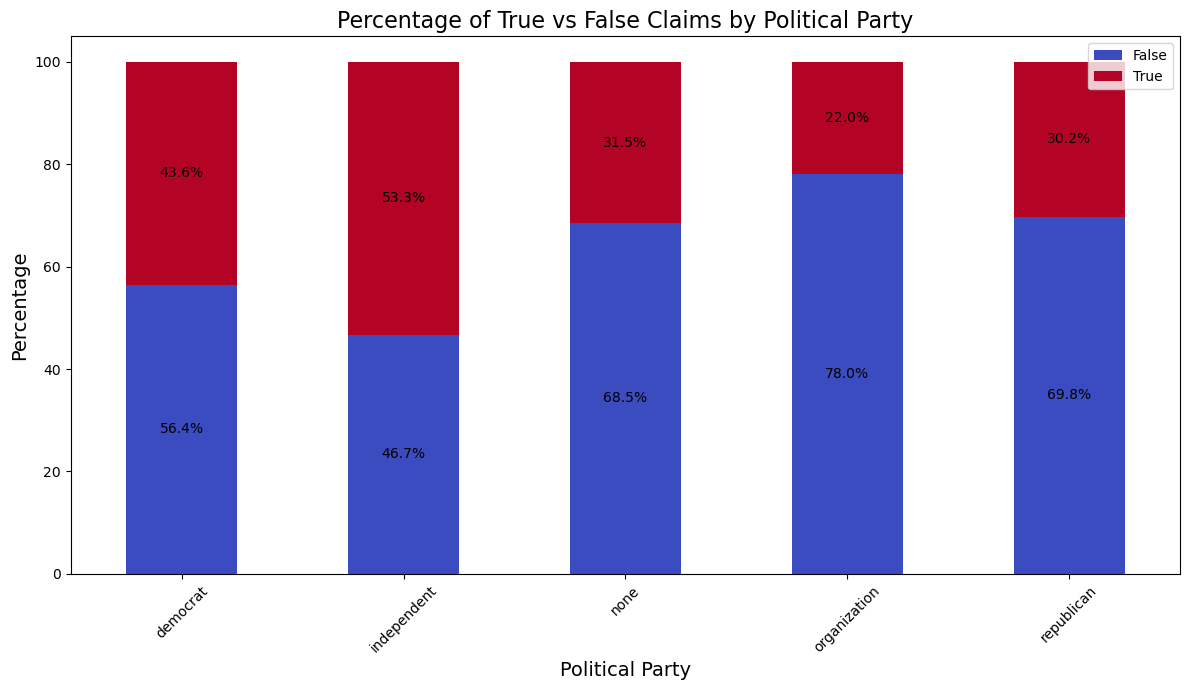

In [10]:
create_three_key_visualizations(train_df, valid_df, test_df)

In [11]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

#  Loading the Tokenizer and other Model
BERT_MODEL = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=2).to("cuda")

# Preparing the  Dataset
def tokenize_function(examples):
    return tokenizer(examples["statement"], padding="max_length", truncation=True, max_length=256)

train_dataset = HFDataset.from_pandas(train_df[["statement", "label"]])
valid_dataset = HFDataset.from_pandas(valid_df[["statement", "label"]])
train_dataset = train_dataset.map(tokenize_function, batched=True)
valid_dataset = valid_dataset.map(tokenize_function, batched=True)
train_dataset = train_dataset.remove_columns(["statement"])
valid_dataset = valid_dataset.remove_columns(["statement"])
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
valid_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

#  Training Config
training_args = TrainingArguments(
    output_dir="./bert_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,  
    gradient_accumulation_steps=2,
    weight_decay=0.01,
    logging_steps=20,
    load_best_model_at_end=True,
    fp16=True,
)

# Train Model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
)

trainer.train()

# Evaluate BERT Model
results = trainer.evaluate()
print(f" BERT Test Accuracy: {results['eval_loss']:.2f}")


F:\Anaconda\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a

Map:   0%|          | 0/10240 [00:00<?, ? examples/s]

Map:   0%|          | 0/1284 [00:00<?, ? examples/s]

F:\Anaconda\Lib\site-packages\accelerate\accelerator.py:427: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
F:\Anaconda\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
F:\Anaconda\Lib\site-packages\accelerate\accelerator.py:1301: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  new_forward = torch.cuda.amp.autocast(dtype=torch.float16)(model_forward_func)
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` me

Epoch,Training Loss,Validation Loss
1,0.647400,0.599335
2,0.568600,0.588051
3,0.453000,0.649924
4,0.387900,0.710637


F:\Anaconda\Lib\site-packages\transformers\trainer.py:2254: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, map_location="cpu")


 BERT Test Accuracy: 0.59


In [12]:
#  Load RoBERTa Model
ROBERTA_MODEL = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(ROBERTA_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(ROBERTA_MODEL, num_labels=2).to("cuda")

# Train and Evaluate using Same Code as BERT
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
)

trainer.train()
results = trainer.evaluate()
print(f" RoBERTa Test Accuracy: {results['eval_loss']:.2f}")


F:\Anaconda\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificatio

Epoch,Training Loss,Validation Loss
1,0.666800,0.639747
2,0.656400,0.633133
3,0.653700,0.632979
4,0.671700,0.632951


F:\Anaconda\Lib\site-packages\transformers\trainer.py:2254: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, map_location="cpu")


 RoBERTa Test Accuracy: 0.63


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoModel, AutoTokenizer

#  Loading Tokenizer and BERT Model
HYBRID_MODEL = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(HYBRID_MODEL)

# Tokenize all the  Text Data
def tokenize_statements(statements):
    return tokenizer(statements, padding="max_length", truncation=True, max_length=256, return_tensors="pt")

train_tokens = tokenize_statements(train_df["statement"].tolist())
valid_tokens = tokenize_statements(valid_df["statement"].tolist())

# Convert  the data to TensorDataset
train_labels = torch.tensor(train_df["label"].tolist())
valid_labels = torch.tensor(valid_df["label"].tolist())
train_dataset = TensorDataset(train_tokens["input_ids"], train_tokens["attention_mask"], train_labels)
valid_dataset = TensorDataset(valid_tokens["input_ids"], valid_tokens["attention_mask"], valid_labels)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

# Defining Hybrid Model made by 3 models BERT + CNN + LSTM
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        
        # Using AutoModel 
        self.bert = AutoModel.from_pretrained(HYBRID_MODEL)
        
        # the CNN Layer
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=128, kernel_size=3, padding=1)
        
        # the LSTM Layer
        self.lstm = nn.LSTM(128, 64, batch_first=True)
        
        # the Fully Connected Layer
        self.fc = nn.Linear(64, 2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask):
        #  Passing through BERT and get hidden states
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state  # batch_size, seq_length, 768

        # Rearrange for Conv1D: batch_size, 768, seq_length
        x = x.permute(0, 2, 1)
        x = self.conv1(x)  # batch_size, 128, seq_length

        # Rearrange for LSTM: batch_size, seq_length, 128
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)  # batch_size, seq_length, 64

        # Take the last LSTM output
        x = x[:, -1, :]  # batch_size, 64

        # Fully Connected Layer
        x = self.fc(self.dropout(x))  # batch_size, 2
        return x

# Initialize Model
model = HybridModel().to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Training theHybrid Model
for epoch in range(4):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = [x.to("cuda") for x in batch]
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Evaluating Hybrid Model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = [x.to("cuda") for x in batch]
        outputs = model(input_ids, attention_mask)
        predictions = torch.argmax(outputs, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f" Hybrid Model Test Accuracy: {accuracy * 100:.2f}% ")


F:\Anaconda\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing

Epoch 1, Loss: 403.2807
Epoch 2, Loss: 378.2158
Epoch 3, Loss: 324.5992
Epoch 4, Loss: 230.8924
 Hybrid Model Test Accuracy: 64.56% 
